In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, label_binarize, OrdinalEncoder
from category_encoders import CatBoostEncoder, MEstimateEncoder

from sklearn.ensemble import RandomForestClassifier, VotingClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.linear_model import RidgeClassifier, LogisticRegression, LinearRegression, Ridge, BayesianRidge

from sklearn import set_config
import os

import optuna
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve, make_scorer, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, matthews_corrcoef, mean_absolute_percentage_error
from scipy.stats import norm, skew

from colorama import Fore, Style, init
from copy import deepcopy
from sklearn.base import BaseEstimator, TransformerMixin
from pprint import pprint
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold, KFold, RepeatedKFold, cross_val_score, StratifiedGroupKFold, GroupKFold
from xgboost import DMatrix, XGBClassifier, XGBRegressor
from lightgbm import log_evaluation, early_stopping, LGBMClassifier, LGBMRegressor, Dataset
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from tqdm.notebook import tqdm
from optuna.samplers import TPESampler, CmaEsSampler
from optuna.pruners import HyperbandPruner
from functools import partial
from IPython.display import display_html, clear_output
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
import gc
import re
import holidays
import requests

import warnings
warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


<p>Configuration</p>

In [2]:
class Config:
    
    state = 4152
    n_splits = 5
    early_stop = 200
        
    target = 'num_sold'
    train = pd.read_csv('./pgs51/datadown/train.csv', index_col='id')
    test = pd.read_csv('./pgs51/datadown/test.csv', index_col='id')
    submission = pd.read_csv('./pgs51/datadown/sample_submission.csv')

    original_data = 'N'
    outliers = 'N'
    log_trf = 'Y'
    scaler_trf = 'N'
    feature_eng = 'Y'
    missing = 'Y'

In [3]:
class EDA(Config):
    
    def __init__(self):
        super().__init__()

        self.cat_features = self.train.drop(self.target, axis=1).select_dtypes(include=['object']).columns.tolist()
        self.num_features = self.train.drop(self.target, axis=1).select_dtypes(exclude=['object']).columns.tolist()
        self.data_info()
        self.cat_feature_plots()
        self.target_plot()
                
    def data_info(self):
        
        for data, label in zip([self.train, self.test], ['Train', 'Test']):
            table_style = [{'selector': 'th:not(.index_name)',
                            'props': [('background-color', '#3cb371'),
                                      ('color', '#FFFFFF'),
                                      ('font-weight', 'bold'),
                                      ('border', '1px solid #DCDCDC'),
                                      ('text-align', 'center')]
                            }, 
                            {'selector': 'tbody td',
                             'props': [('border', '1px solid #DCDCDC'),
                                       ('font-weight', 'normal')]
                            }]
            print(Style.BRIGHT+Fore.GREEN+f'\n{label} head\n')
            display(data.head().style.set_table_styles(table_style))
                           
            print(Style.BRIGHT+Fore.GREEN+f'\n{label} info\n'+Style.RESET_ALL)               
            display(data.info())
            
            print(Style.BRIGHT+Fore.GREEN+f'\n{label} missing values\n'+Style.RESET_ALL)               
            display(data.isna().sum())
        return self
        
    def cat_feature_plots(self):
        fig, axes = plt.subplots(len(self.cat_features), 2 ,figsize = (18, len(self.cat_features) * 6), 
                                 gridspec_kw = {'hspace': 0.5, 
                                                'wspace': 0.2,
                                               }
                                )

        for i, col in enumerate(self.cat_features):
            
            ax = axes[i,0]
            sns.barplot(data=self.train[col].value_counts().nlargest(10).reset_index(), x=col, y='count', ax=ax, color='#3cb371')
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col} Train")
            
            ax = axes[i,1]
            sns.barplot(data=self.train[col].value_counts().nlargest(10).reset_index(), x=col, y='count', ax=ax, color='r')
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col} Test")

        plt.tight_layout()
        plt.show()
        
    def target_plot(self):
        print(Style.BRIGHT+Fore.GREEN+f"\nTarget feature distribution\n")
        
        fig, axes = plt.subplots(1, 2 ,figsize = (14, 6), 
                                 gridspec_kw = {'hspace': 0.3, 
                                                'wspace': 0.2, 
                                                'width_ratios': [0.70, 0.30]
                                               }
                                )
        ax = axes[0]
        sns.kdeplot(data = self.train[self.target], 
                    color = '#3cb371', ax = ax, linewidth = 2
                   )
        ax.set(xlabel = '', ylabel = '')
        ax.set_title(f"\n{self.target}")
        ax.grid()

        ax = axes[1]
        sns.boxplot(data = self.train, y = self.target, width = 0.5,
                    linewidth = 1, fliersize= 1,
                    ax = ax, color = '#3cb371'
                   )
        ax.set_title(f"\n{self.target}")
        ax.set(xlabel = '', ylabel = '')
        ax.tick_params(axis='both', which='major')

        plt.tight_layout()
        plt.show()         

In [4]:
# eda = EDA()

## Data Transformation

In [5]:
class Transform(Config):

    def __init__(self):
        super().__init__()
        if Config.original_data == "Y":
            self.train = pd.concat(
                [self.train, self.train_org], ignore_index=True
            ).drop_duplicates()
            self.train.reset_index(drop=True, inplace=True)

        self.num_features = (
            self.train.drop(self.target, axis=1)
            .select_dtypes(exclude=["object", "bool"])
            .columns.tolist()
        )
        self.cat_features = (
            self.train.drop(self.target, axis=1)
            .select_dtypes(include=["object", "bool"])
            .columns.tolist()
        )

        self.train_raw = self.train.copy()

        if self.feature_eng == "Y":
            self.train = self.new_features(self.train)
            self.test = self.new_features(self.test)
            self.train_raw = self.new_features(self.train_raw)

        if self.missing == "Y":
            self.missing_values()

        self.num_features = (
            self.train.drop(self.target, axis=1)
            .select_dtypes(exclude=["object", "bool"])
            .columns.tolist()
        )
        self.cat_features = (
            self.train.drop(self.target, axis=1)
            .select_dtypes(include=["object", "bool"])
            .columns.tolist()
        )

        if self.outliers == "Y":
            self.remove_outliers()

        if self.log_trf == "Y":
            self.log_transformation()

        if self.scaler_trf == "Y":
            self.scaler()

        self.train_enc = self.train.copy()
        self.test_enc = self.test.copy()
        self.encode()

        if self.outliers == "Y" or self.log_trf == "Y" or self.scaler_trf == "Y":
            self.distribution()

    def __call__(self):

        self.train[self.cat_features] = self.train[self.cat_features].astype("category")
        self.test[self.cat_features] = self.test[self.cat_features].astype("category")

        self.cat_features_card = []
        for f in self.cat_features:
            self.cat_features_card.append(self.train[f].nunique())

        self.train = self.reduce_mem(self.train)
        self.test = self.reduce_mem(self.test)

        self.y = self.train[self.target]
        self.train = self.train.drop(self.target, axis=1)
        self.train_enc = self.train_enc.drop(self.target, axis=1)

        return (
            self.train,
            self.train_enc,
            self.y,
            self.test,
            self.test_enc,
            self.cat_features,
        )

    def encode(self):
        data = pd.concat([self.test, self.train])
        oe = OrdinalEncoder()
        data[self.cat_features] = oe.fit_transform(data[self.cat_features]).astype(
            "int"
        )

        scaler = StandardScaler()
        data[self.num_features + [self.target]] = scaler.fit_transform(
            data[self.num_features + [self.target]]
        )

        self.train_enc = data[~data[self.target].isna()]
        self.test_enc = data[data[self.target].isna()].drop(self.target, axis=1)

    def new_features(self, data):
        data["date"] = pd.to_datetime(data["date"])
        data["quarter"] = data["date"].dt.quarter.astype("object")
        data["month"] = data["date"].dt.month
        data["month_sin"] = np.sin(data["month"] * (2 * np.pi / 12))
        data["month_cos"] = np.cos(data["month"] * (2 * np.pi / 12))
        data["day"] = data["date"].dt.day
        data["day_sin"] = np.sin(data["day"] * (2 * np.pi / 31))
        data["day_cos"] = np.cos(data["day"] * (2 * np.pi / 31))
        data["day_of_week"] = data["date"].dt.dayofweek.astype("object")
        data["day_of_year"] = data["date"].dt.dayofyear.astype("object")
        data["day_of_week"] = data["day_of_week"].apply(
            lambda x: 0 if x <= 3 else (1 if x == 4 else (2 if x == 5 else (3)))
        )
        data["week"] = data["date"].dt.isocalendar().week
        data["week_sin"] = np.sin(data["week"] * (2 * np.pi / 53))
        data["week_cos"] = np.cos(data["week"] * (2 * np.pi / 53))
        data["year"] = data["date"].dt.year
        data["cos_year"] = np.cos(data["year"] * (2 * np.pi) / 100)
        data["sin_year"] = np.sin(data["year"] * (2 * np.pi) / 100)
        data[["month", "day", "week", "year"]] = data[
            ["month", "day", "week", "year"]
        ].astype("object")
        data["group"] = (
            (data["year"] - 2020) * 48 + data["month"] * 4 + data["day"] // 7
        )
        data = pd.get_dummies(data, columns=["day_of_week"], drop_first=True)
        data["important_dates"] = data["day_of_year"].apply(
            lambda x: (
                x
                if x
                in [
                    1,
                    2,
                    3,
                    4,
                    5,
                    6,
                    7,
                    8,
                    9,
                    10,
                    99,
                    100,
                    101,
                    125,
                    126,
                    355,
                    256,
                    357,
                    358,
                    359,
                    360,
                    361,
                    362,
                    363,
                    364,
                    365,
                ]
                else 0
            )
        )
        data.drop(columns=["day_of_year"], inplace=True)

        for day in range(24, 32):
            data[f"dec{day}"] = (
                (data.date.dt.day.eq(day) & data.date.dt.month.eq(12))
                .astype(np.uint8)
                .astype("object")
            )

        alpha2 = dict(
            zip(np.sort(data.country.unique()), ["CA", "FI", "IT", "KE", "NO", "SG"])
        )
        h = {
            c: holidays.country_holidays(a, years=range(2010, 2020))
            for c, a in alpha2.items()
        }
        data["is_holiday"] = 0
        for c in alpha2:
            data.loc[data.country == c, "is_holiday"] = (
                data.date.isin(h[c]).astype(int).astype("object")
            )

        try:
            gdp_df = pd.read_csv("./pgs51/datadown/data_gdp.csv").drop('Unnamed: 0', axis = 1)
        except:
            print("no gdp data")
        # gdp = []
        # for country in data.country.unique():
        #     row = []
        #     for year in range(2010,2020):
        #         row.append(self.get_gdp(country,year))
        #     gdp.append(row)

        # gdp = np.array(gdp)
        # gdp /= np.sum(gdp,axis=0)

        # gdp_df = pd.DataFrame(gdp, index=data.country.unique(), columns=range(2010,2020))
        # gdp_df = gdp_df.reset_index().melt(id_vars = ['index']).rename({'index': 'country', 'variable': 'year', 'value': 'GDP'}, axis=1)
        data = data.merge(gdp_df, how="left", on=["year", "country"])
        return data

    def log_transformation(self):
        self.train[self.target] = np.log1p(self.train[self.target])
        return self

    def distribution(self):
        print(Style.BRIGHT + Fore.GREEN + f"\nHistograms of distribution\n")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

        ax_r, ax_n = axes

        ax_r.set_title(
            f"{self.target} ($\mu=$ {self.train_raw[self.target].mean():.2f} and $\sigma=$ {self.train_raw[self.target].std():.2f} )"
        )
        ax_r.hist(self.train_raw[self.target], bins=30, color="#3cb371")
        ax_r.axvline(self.train_raw[self.target].mean(), color="r", label="Mean")
        ax_r.axvline(
            self.train_raw[self.target].median(),
            color="y",
            linestyle="--",
            label="Median",
        )
        ax_r.legend()

        ax_n.set_title(
            f"{self.target} Normalized ($\mu=$ {self.train_enc[self.target].mean():.2f} and $\sigma=$ {self.train_enc[self.target].std():.2f} )"
        )
        ax_n.hist(self.train_enc[self.target], bins=30, color="#3cb371")
        ax_n.axvline(self.train_enc[self.target].mean(), color="r", label="Mean")
        ax_n.axvline(
            self.train_enc[self.target].median(),
            color="y",
            linestyle="--",
            label="Median",
        )
        ax_n.legend()

    def remove_outliers(self):
        Q1 = self.train[self.targets].quantile(0.25)
        Q3 = self.train[self.targets].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        self.train = self.train[
            (self.train[self.targets] >= lower_limit)
            & (self.train[self.targets] <= upper_limit)
        ]
        self.train.reset_index(drop=True, inplace=True)

    def scaler(self):
        scaler = StandardScaler()
        self.train[self.num_features] = scaler.fit_transform(
            self.train[self.num_features]
        )
        self.test[self.num_features] = scaler.transform(self.test[self.num_features])
        return self

    def missing_values(self):
        train_df_imputed = self.train.copy()
        for year in train_df_imputed["year"].unique():
            target_ratio = train_df_imputed.loc[
                (train_df_imputed["year"] == year)
                & (train_df_imputed["country"] == "Norway"),
                "GDP",
            ].values[0]
            current_raito = train_df_imputed.loc[
                (train_df_imputed["year"] == year)
                & (train_df_imputed["country"] == "Canada"),
                "GDP",
            ].values[0]
            ratio_can = current_raito / target_ratio
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Canada")
                & (train_df_imputed["store"] == "Discount Stickers")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year),
                "num_sold",
            ] = (
                train_df_imputed.loc[
                    (train_df_imputed["country"] == "Norway")
                    & (train_df_imputed["store"] == "Discount Stickers")
                    & (train_df_imputed["product"] == "Holographic Goose")
                    & (train_df_imputed["year"] == year),
                    "num_sold",
                ]
                * ratio_can
            ).values

            current_ts = train_df_imputed.loc[
                (train_df_imputed["country"] == "Canada")
                & (train_df_imputed["store"] == "Premium Sticker Mart")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
            ]
            missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Canada")
                & (train_df_imputed["store"] == "Premium Sticker Mart")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
                & (train_df_imputed["date"].isin(missing_ts_dates)),
                "num_sold",
            ] = (
                train_df_imputed.loc[
                    (train_df_imputed["country"] == "Norway")
                    & (train_df_imputed["store"] == "Premium Sticker Mart")
                    & (train_df_imputed["product"] == "Holographic Goose")
                    & (train_df_imputed["year"] == year)
                    & (train_df_imputed["date"].isin(missing_ts_dates)),
                    "num_sold",
                ]
                * ratio_can
            ).values

            current_ts = train_df_imputed.loc[
                (train_df_imputed["country"] == "Canada")
                & (train_df_imputed["store"] == "Stickers for Less")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
            ]
            missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Canada")
                & (train_df_imputed["store"] == "Stickers for Less")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
                & (train_df_imputed["date"].isin(missing_ts_dates)),
                "num_sold",
            ] = (
                train_df_imputed.loc[
                    (train_df_imputed["country"] == "Norway")
                    & (train_df_imputed["store"] == "Stickers for Less")
                    & (train_df_imputed["product"] == "Holographic Goose")
                    & (train_df_imputed["year"] == year)
                    & (train_df_imputed["date"].isin(missing_ts_dates)),
                    "num_sold",
                ]
                * ratio_can
            ).values

            current_raito = train_df_imputed.loc[
                (train_df_imputed["year"] == year)
                & (train_df_imputed["country"] == "Kenya"),
                "GDP",
            ].values[0]
            ratio_ken = current_raito / target_ratio
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Kenya")
                & (train_df_imputed["store"] == "Discount Stickers")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year),
                "num_sold",
            ] = (
                train_df_imputed.loc[
                    (train_df_imputed["country"] == "Norway")
                    & (train_df_imputed["store"] == "Discount Stickers")
                    & (train_df_imputed["product"] == "Holographic Goose")
                    & (train_df_imputed["year"] == year),
                    "num_sold",
                ]
                * ratio_ken
            ).values

            current_ts = train_df_imputed.loc[
                (train_df_imputed["country"] == "Kenya")
                & (train_df_imputed["store"] == "Premium Sticker Mart")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
            ]
            missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Kenya")
                & (train_df_imputed["store"] == "Premium Sticker Mart")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
                & (train_df_imputed["date"].isin(missing_ts_dates)),
                "num_sold",
            ] = (
                train_df_imputed.loc[
                    (train_df_imputed["country"] == "Norway")
                    & (train_df_imputed["store"] == "Premium Sticker Mart")
                    & (train_df_imputed["product"] == "Holographic Goose")
                    & (train_df_imputed["year"] == year)
                    & (train_df_imputed["date"].isin(missing_ts_dates)),
                    "num_sold",
                ]
                * ratio_ken
            ).values

            current_ts = train_df_imputed.loc[
                (train_df_imputed["country"] == "Kenya")
                & (train_df_imputed["store"] == "Stickers for Less")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
            ]
            missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Kenya")
                & (train_df_imputed["store"] == "Stickers for Less")
                & (train_df_imputed["product"] == "Holographic Goose")
                & (train_df_imputed["year"] == year)
                & (train_df_imputed["date"].isin(missing_ts_dates)),
                "num_sold",
            ] = (
                train_df_imputed.loc[
                    (train_df_imputed["country"] == "Norway")
                    & (train_df_imputed["store"] == "Stickers for Less")
                    & (train_df_imputed["product"] == "Holographic Goose")
                    & (train_df_imputed["year"] == year)
                    & (train_df_imputed["date"].isin(missing_ts_dates)),
                    "num_sold",
                ]
                * ratio_ken
            ).values

            current_ts = train_df_imputed.loc[
                (train_df_imputed["country"] == "Kenya")
                & (train_df_imputed["store"] == "Discount Stickers")
                & (train_df_imputed["product"] == "Kerneler")
                & (train_df_imputed["year"] == year)
            ]
            missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Kenya")
                & (train_df_imputed["store"] == "Discount Stickers")
                & (train_df_imputed["product"] == "Kerneler")
                & (train_df_imputed["year"] == year)
                & (train_df_imputed["date"].isin(missing_ts_dates)),
                "num_sold",
            ] = (
                train_df_imputed.loc[
                    (train_df_imputed["country"] == "Norway")
                    & (train_df_imputed["store"] == "Discount Stickers")
                    & (train_df_imputed["product"] == "Kerneler")
                    & (train_df_imputed["year"] == year)
                    & (train_df_imputed["date"].isin(missing_ts_dates)),
                    "num_sold",
                ]
                * ratio_ken
            ).values

        train_df_imputed.loc[train_df_imputed.index == 23719, "num_sold"] = 4
        train_df_imputed.loc[train_df_imputed.index == 207003, "num_sold"] = 195
        self.train = train_df_imputed.drop("date", axis=1)
        self.test.drop("date", axis=1, inplace=True)
        return self

    def reduce_mem(self, df):

        numerics = [
            "int16",
            "int32",
            "int64",
            "float16",
            "float32",
            "float64",
            "uint16",
            "uint32",
            "uint64",
        ]

        for col in df.columns:
            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if "int" in str(col_type):
                    if c_min >= np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif (
                        c_min >= np.iinfo(np.int16).min
                        and c_max < np.iinfo(np.int16).max
                    ):
                        df[col] = df[col].astype(np.int16)
                    elif (
                        c_min >= np.iinfo(np.int32).min
                        and c_max < np.iinfo(np.int32).max
                    ):
                        df[col] = df[col].astype(np.int32)
                    elif (
                        c_min >= np.iinfo(np.int64).min
                        and c_max < np.iinfo(np.int64).max
                    ):
                        df[col] = df[col].astype(np.int64)
                else:
                    if (
                        c_min >= np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                    ):
                        df[col] = df[col].astype(np.float16)
                    if (
                        c_min >= np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                    ):
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

        return df

    def get_gdp(self, country, year):
        alpha3 = {
            "Canada": "CAN",
            "Finland": "FIN",
            "Italy": "ITA",
            "Kenya": "KEN",
            "Norway": "NOR",
            "Singapore": "SGP",
        }

        url = "https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json".format(
            alpha3[country], year
        )
        response = requests.get(url).json()
        return response[1][0]["value"]


Histograms of distribution



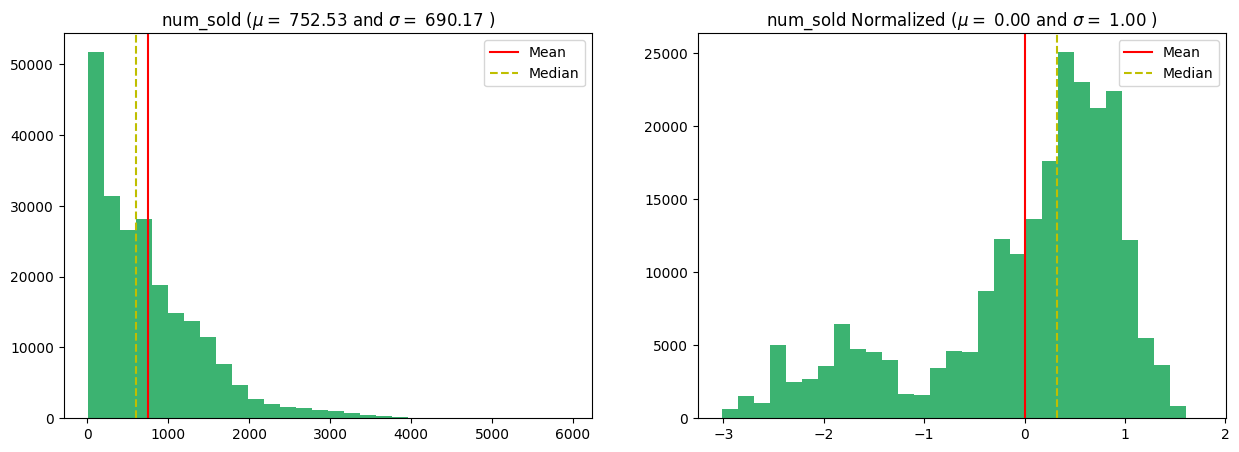

In [22]:
# 15 sec
t = Transform()
X, X_enc, y, test, test_enc, cat_features = t()
# X, X_enc, y, test, test_enc = 0, 0, 0, 0, 0

In [30]:
import pprint
X[cat_features].apply("nunique").tolist(), X_enc[cat_features].apply("nunique").tolist(), test[cat_features].apply("nunique").tolist(), test_enc[cat_features].apply("nunique").tolist()

([6, 3, 5, 4, 12, 31, 53, 7, 337, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [6, 3, 5, 4, 12, 31, 53, 7, 337, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [6, 3, 5, 4, 12, 31, 52, 3, 145, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [6, 3, 5, 4, 12, 31, 52, 3, 145, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [32]:
t.cat_features_card

[6, 3, 5, 4, 12, 31, 53, 7, 337, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [36]:
test_enc['country'].unique()

array([0, 1, 2, 3, 4, 5])

In [37]:
# s = {}
# for  j in ['X', "X_enc", 'y', "test", "test_enc",]:
#     s[j] = pd.read_csv(f'./pgs51/dataup/data_{j}.csv').drop("Unnamed: 0", axis = 1)
# s.keys()
# # X = s['X']
# # X_enc = s['X_enc']
# # y = s['y']
# # test = s['test']
# # test_enc = s['test_enc']


## Model Training

In [38]:
from sklearn.base import BaseEstimator, RegressorMixin
import contextlib, io
import ydf; ydf.verbose(2)
from ydf import GradientBoostedTreesLearner

def YDFRegressor(learner_class):

    class YDFXRegressor(BaseEstimator, RegressorMixin):

        def __init__(self, params={}):
            self.params = params

        def fit(self, X, y):
            assert isinstance(X, pd.DataFrame)
            assert isinstance(y, pd.Series)
            target = y.name
            params = self.params.copy()
            params['label'] = target
            params['task'] = ydf.Task.REGRESSION
            X = pd.concat([X, y], axis=1)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                self.model = learner_class(**params).train(X)
            return self

        def predict(self, X):
            assert isinstance(X, pd.DataFrame)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                return self.model.predict(X)

    return YDFXRegressor

In [39]:
def build_model():
    
    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(t.cat_features_card[j], int(np.ceil(np.sqrt(t.cat_features_card[j]))))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)
        
    x_input_nums = layers.Input(shape=(len(t.num_features),))
    
    x = layers.Concatenate(axis=-1)(embs+[x_input_nums]) 
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1)(x)
    
    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x)
    return model


In [51]:
models = {
    # 'NN': [_,
    #        True],
    # 'CAT': [CatBoostRegressor(**{'verbose': 0,
    #                              'random_state': Config.state,
    #                              'cat_features': cat_features,
    #                              'early_stopping_rounds': Config.early_stop,
    #                              'eval_metric': "RMSE",
    #                              'n_estimators' : 2000,
    #                              'depth': 3,
    #                              'min_data_in_leaf': 96,
    #                              'l2_leaf_reg': 8.972890275248485,
    #                              'bagging_temperature': 0.18658249870341914, 
    #                              'random_strength': 0.14106593468982453,
    #                              'learning_rate': 0.01,
    #                             }),
    #         True],
    # 'CAT3': [CatBoostRegressor(**{'verbose': 0,
    #                               'random_state': Config.state,
    #                               'cat_features': cat_features,
    #                               'early_stopping_rounds': Config.early_stop,
    #                               'eval_metric': "MAPE",
    #                               'n_estimators' : 2000,
    #                               'learning_rate': 0.01,
    #                               'depth': 8,
    #                               'min_data_in_leaf': 99,
    #                               'l2_leaf_reg': 7.7324870113971125, 
    #                               'bagging_temperature': 0.003232535109945575, 
    #                               'random_strength': 0.12145610701952099,
    #                              }),
    #          True],
    # 'CAT5': [CatBoostRegressor(**{'depth': 7,
    #                               'min_data_in_leaf': 59,
    #                               'l2_leaf_reg': 6.485681470975604, 
    #                               'bagging_temperature': 0.728613892125684,
    #                               'random_strength': 0.3565990691132947,
    #                               'verbose': 0,
    #                               'random_state': Config.state,
    #                               'cat_features': cat_features,
    #                               'early_stopping_rounds': Config.early_stop,
    #                               'eval_metric': "MAPE",
    #                               'n_estimators' : 2000,
    #                               'learning_rate': 0.01,
    #                               "task_type": "cpu",
    #                              }),
    #          True],
    # 'CAT6': [CatBoostRegressor(**{'depth': 10,
    #                               'min_data_in_leaf': 67,
    #                               'l2_leaf_reg': 0.010658988402410939,
    #                               'bagging_temperature': 0.7381549501573549,
    #                               'random_strength': 0.10057316762567874,
    #                               'verbose': 0,
    #                               'random_state': Config.state,
    #                               'cat_features': cat_features,
    #                               'early_stopping_rounds': Config.early_stop,
    #                               'eval_metric': "MAPE",
    #                               'n_estimators' : 2000,
    #                               'learning_rate': 0.01,
    #                               'bootstrap_type': 'Poisson',
    #                               "task_type": "cpu",
    #                              }),
    #          True],
    # 'XGB2': [XGBRegressor(**{'tree_method': 'hist',
    #                          'n_estimators': 2000,
    #                          'objective': 'reg:squarederror',
    #                          'random_state': Config.state,
    #                          'enable_categorical': True,
    #                          'verbosity': 0,
    #                          'early_stopping_rounds': Config.early_stop,
    #                          'eval_metric': 'rmse',
    #                          'booster': 'gbtree', 
    #                          'max_depth': 3,
    #                          'min_child_weight': 16,
    #                          'subsample': 0.8172380854733758, 
    #                          'reg_alpha': 0.2734696712123178, 
    #                          'reg_lambda': 0.5865768393479154,
    #                          'colsample_bytree': 0.9766164536195251,
    #                          'n_jobs': -1,
    #                          'learning_rate': 0.01,
    #                          'n_jobs': -1
    #                         }),
    #         True],
    # 'XGB3': [XGBRegressor(**{'tree_method': 'hist',
    #                          'n_estimators': 2000,
    #                          'learning_rate': 0.01,
    #                          'objective': 'reg:squarederror',
    #                          'random_state': Config.state,
    #                          'enable_categorical': True,
    #                          'verbosity': 0,
    #                          'early_stopping_rounds': Config.early_stop,
    #                          'eval_metric': 'mape',
    #                          'booster': 'gbtree',
    #                          'max_depth': 3,
    #                          'min_child_weight': 12,
    #                          'subsample': 0.7720667996291699, 
    #                          'reg_alpha': 0.07869714859026081, 
    #                          'reg_lambda': 0.9577219578640989, 
    #                          'colsample_bytree': 0.9728085969282255, 
    #                          'n_jobs': -1
    #                        }),
    #     True],
    # 'XGB4': [XGBRegressor(**{'booster': 'gbtree',
    #                          'max_depth': 3,
    #                          'min_child_weight': 12,
    #                          'subsample': 0.800221370346261,
    #                          'reg_alpha': 0.4571249607822852,
    #                          'reg_lambda': 0.6572354640280187,
    #                          'colsample_bytree': 0.9982441671154363,
    #                          'n_jobs': -1,
    #                          'tree_method': 'hist',
    #                          'n_estimators': 3000,
    #                          'learning_rate': 0.01,
    #                          'objective': 'reg:squarederror',
    #                          'random_state': Config.state,
    #                          'enable_categorical': True,
    #                          'verbosity': 0,
    #                          'early_stopping_rounds': Config.early_stop,
    #                          'eval_metric': 'mape',
    #                          'booster': 'gbtree',
    #                          "device": "cuda",
    #                         }),
    #          True],
    # 'XGB5': [XGBRegressor(**{'booster': 'gbtree',
    #                          'max_depth': 3,
    #                          'min_child_weight': 19,
    #                          'subsample': 0.8065343833518619,
    #                          'reg_alpha': 0.3577049940509907,
    #                          'reg_lambda': 0.8560297700871249,
    #                          'colsample_bytree': 0.9866141987520272,
    #                          'objective': 'reg:squarederror',
    #                          'n_jobs': -1,
    #                          'tree_method': 'hist',
    #                          'n_estimators': 3000,
    #                          'learning_rate': 0.01,
    #                          'random_state': Config.state,
    #                          'enable_categorical': True,
    #                          'verbosity': 0,
    #                          'early_stopping_rounds': Config.early_stop,
    #                          'eval_metric': 'mape', 
    #                          "device": "cuda",
    #                          }),
    #          True],
    'LGBM2': [LGBMRegressor(**{'random_state': Config.state,
                               'early_stopping_round': Config.early_stop,
                               'categorical_feature': cat_features,
                               'verbose': -1,
                               'boosting_type': 'gbdt',
                               'eval_metric': 'rmse',
                               'objective': 'regression_l2',
                               'n_estimators': 5000,
                               'max_depth': 13, 
                               'num_leaves': 891, 
                               'min_child_samples': 16,
                               'min_child_weight': 11,
                               'colsample_bytree': 0.48639630433139497,
                               'reg_alpha': 0.45496760242817474,
                               'reg_lambda': 0.9669296995303693,
                               'learning_rate': 0.01
                              }),
             True],
    'LGBM3': [LGBMRegressor(**{'random_state': Config.state,
                               'early_stopping_round': Config.early_stop,
                               'categorical_feature': cat_features,
                               'verbose': -1,
                               'boosting_type': 'gbdt',
                               'eval_metric': 'rmse',
                               'objective': 'regression_l2',
                               'n_estimators': 2000,
                               'max_depth': 6, 
                               'num_leaves': 328,
                               'min_child_samples': 10,
                               'min_child_weight': 16,
                               'colsample_bytree': 0.4893394195489041,
                               'reg_alpha': 0.18334253987924942,
                               'reg_lambda': 0.8328414321738785,
                               'learning_rate': 0.01
                              }),
             True],
    'LGBM4': [LGBMRegressor(**{'objective': 'regression_l2',
                               'metric': 'mape', 
                               'max_depth': 12, 
                               'num_leaves': 878,
                               'min_child_samples': 29,
                               'min_child_weight': 14,
                               'colsample_bytree': 0.49788260207319734, 
                               'reg_alpha': 0.4747476308475839, 
                               'reg_lambda': 0.6960820486441526,
                               'random_state': Config.state,
                               'early_stopping_round': Config.early_stop,
                               'categorical_feature': cat_features,
                               'verbose': -1,
                               'boosting_type': 'gbdt',
                               'eval_metric': 'mape',
                               'objective': 'regression_l2',
                               'n_estimators': 3000,
                               'learning_rate': 0.01,
                               }),
              True],
    'LGBM5': [LGBMRegressor(**{'objective': 'regression_l2',
                               'metric': 'mape', 
                               'max_depth': 7,
                               'num_leaves': 123, 
                               'min_child_samples': 21,
                               'min_child_weight': 24,
                               'colsample_bytree': 0.3641261996760593, 
                               'reg_alpha': 0.03632800166349373, 
                               'reg_lambda': 0.5287861861476272,
                               'random_state': Config.state,
                               'early_stopping_round': Config.early_stop,
                               'categorical_feature': cat_features,
                               'verbose': -1,
                               'boosting_type': 'gbdt',
                               'n_estimators': 3000,
                               'learning_rate': 0.01,
                               }),
              True],
    'LGBM6': [LGBMRegressor(**{'objective': 'regression_l2',
                               'metric': 'mape',
                               'max_depth': 6,
                               'num_leaves': 502,
                               'min_child_samples': 23,
                               'min_child_weight': 18, 
                               'colsample_bytree': 0.4714820876493163, 
                               'reg_alpha': 0.054972003081022576, 
                               'reg_lambda': 0.5774608955362155,
                               'random_state': Config.state,
                               'early_stopping_round': Config.early_stop,
                               'categorical_feature': cat_features,
                               'verbose': -1,
                               'boosting_type': 'goss',
                               'n_estimators': 3000,
                               'learning_rate': 0.01,
                              }),
             True],
    'LGBM7': [LGBMRegressor(**{'objective': 'regression_l2', 
                               'metric': 'mape',
                               'max_depth': 14,
                               'num_leaves': 279,
                               'min_child_samples': 7,
                               'min_child_weight': 24, 
                               'colsample_bytree': 0.43218993309765835,
                               'reg_alpha': 0.42757392987472964,
                               'reg_lambda': 0.9039762787446107,
                               'random_state': Config.state,
                               'early_stopping_round': Config.early_stop,
                               'categorical_feature': cat_features,
                               'verbose': -1,
                               'boosting_type': 'goss',
                               'n_estimators': 3000,
                               'learning_rate': 0.01,
                               }),
              True],
    'Ridge': [Ridge(tol=1e-2, max_iter=1000000,
                    random_state=Config.state),
              False],
    'BRidge': [BayesianRidge(tol=1e-2, max_iter=1000000),
              False],
    'LR': [LinearRegression(),
              False],
    'HGB': [HistGradientBoostingRegressor(**{'max_depth': 4,
                                             'loss': 'squared_error',
                                             'l2_regularization': 0.014082438341668873,
                                             'min_samples_leaf': 39,
                                             'max_leaf_nodes': 25,
                                             'learning_rate': 0.01,
                                             'max_iter': 2000,
                                             'random_state': Config.state,
                                             'early_stopping': Config.early_stop,
                                            }),
              False],
    'HGB2': [HistGradientBoostingRegressor(**{'max_depth': 4,
                                              'loss': 'squared_error',
                                              'l2_regularization': 1.0294569289519551e-05,
                                              'min_samples_leaf': 12, 
                                              'max_leaf_nodes': 26,
                                              'learning_rate': 0.01,
                                              'max_iter': 2000,
                                              'random_state': Config.state,
                                              'early_stopping': Config.early_stop,
                                             }),
             False],
    'HGB3': [HistGradientBoostingRegressor(**{'max_depth': 13, 
                                              'loss': 'squared_error',
                                              'l2_regularization': 0.05253480068908677,
                                              'min_samples_leaf': 19,
                                              'max_leaf_nodes': 40,
                                              'learning_rate': 0.01,
                                              'max_iter': 3000,
                                              'random_state': Config.state,
                                              'early_stopping': Config.early_stop,
                                             }),
             False],
    'HGB4': [HistGradientBoostingRegressor(**{'max_depth': 4, 
                                              'loss': 'squared_error', 
                                              'l2_regularization': 1.3248236291502028e-09,
                                              'min_samples_leaf': 39,
                                              'max_leaf_nodes': 29,
                                              'learning_rate': 0.01,
                                              'max_iter': 3000,
                                              'random_state': Config.state,
                                              'early_stopping': Config.early_stop,
                                             }),
             False],
    'YDF': [YDFRegressor(GradientBoostedTreesLearner)({'num_trees': 1000,
                                                       'max_depth': 13,
                                                       }),
            False]
}

In [52]:
class Model(Config):
    
    def __init__(self, X, X_enc, y, test, test_enc, models):
        self.y = y
        self.models = models
        self.scores = pd.DataFrame(columns=['Score'])
        self.OOF_preds = pd.DataFrame()
        self.TEST_preds = pd.DataFrame()
        self.folds = GroupKFold(n_splits=self.n_splits)
        self.model = None
        self.model_dir = './pgs51/models/'

    def train(self):      
        
        for model_name, [model, training] in tqdm(self.models.items()):
            
            if training:
                print('='*20)
                print(model_name)
                if any(model in model_name for model in ['LGBM', 'CAT', 'XGB']):
                    self.X = X
                    self.test = test
 
                else:
                    self.X = X_enc
                    self.test = test_enc
                    
                if 'NN' in model_name:
                    for n_fold, (train_id, valid_id) in enumerate(self.folds.split(self.X, self.y, groups = X['year'])):

                        X_train_cats = self.X.loc[train_id, cat_features]
                        X_train_nums = self.X.loc[train_id, t.num_features]
                        y_train = self.y.loc[train_id].values

                        X_val_cats = self.X.loc[valid_id, cat_features]
                        X_val_nums = self.X.loc[valid_id, t.num_features]
                        y_val = self.y.loc[valid_id]

                        X_test_cats = self.test[cat_features]
                        X_test_nums = self.test[t.num_features]
        
                        oof_preds = pd.DataFrame(columns=[model_name], index=X_val_cats.index)
                        test_preds = pd.DataFrame(columns=[model_name], index=test.index)
                        print(f'Fold {n_fold+1}')
                        
                        model = build_model()                        
                        keras.utils.set_random_seed(self.state)
                        optimizer = keras.optimizers.Adam(learning_rate=1e-3)
                        model.compile(optimizer=optimizer, loss='mean_squared_error')
                        model.fit([X_train_cats,X_train_nums], y_train, 
                                  validation_data=([X_val_cats, X_val_nums], y_val),
                                  epochs=20,
                                  batch_size=1000,
                                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=1),
                                             keras.callbacks.EarlyStopping(patience=3)
                                            ])
                        
                        y_pred_val = model.predict([X_val_cats, X_val_nums])
                        print(X_train_cats.shape, X_train_nums.shape)
                        print(X_test_cats.shape, X_test_nums.shape)
                        test_pred = model.predict([X_test_cats, X_test_nums])
                        
                        score = mean_absolute_percentage_error(y_val, y_pred_val)
                        print(score)
                        self.scores.loc[f'{model_name}', f'Fold {n_fold+1}'] = score
                        
                        oof_preds[model_name] = y_pred_val
                        test_preds[model_name] = test_pred

                        self.OOF_preds  = pd.concat([self.OOF_preds, oof_preds], axis = 0, ignore_index = False)
                        self.TEST_preds = pd.concat([self.TEST_preds, test_preds], axis = 0, ignore_index = False)
                                    
                        # Save the model to a file locally
                        model_save_path = f"{self.model_dir}/{model_name}_fold{n_fold+1}.h5"
                        model.save(model_save_path)
                else:
                    for n_fold, (train_id, valid_id) in enumerate(self.folds.split(self.X, self.y, groups = self.X['year'])):
                        X_train, y_train = self.X.iloc[train_id], self.y.iloc[train_id]
                        X_val, y_val = self.X.iloc[valid_id], self.y.iloc[valid_id]

                        oof_preds = pd.DataFrame(columns=[model_name], index=X_val.index)
                        test_preds = pd.DataFrame(columns=[model_name], index=test.index)
                        print(f'Fold {n_fold+1}')

                        if "XGB" in model_name:
                            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
                            self.model = model
                            # Save XGBoost model
                            model_save_path = f"{self.model_dir}/{model_name}_fold{n_fold+1}.json"
                            model.save_model(model_save_path)
                            print(f"XGBoost model saved to {model_save_path}")
                
                        elif "CAT" in model_name:
                            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
                            # Save CatBoost model
                            self.model = model
                            model_save_path = f"{self.model_dir}/{model_name}_fold{n_fold+1}.cbm"
                            model.save_model(model_save_path)
                            print(f"CatBoost model saved to {model_save_path}")
                
                        elif "LGBM" in model_name:
                            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[log_evaluation(0), early_stopping(self.early_stop, verbose=False)])
                            self.model = model
                            # Save LightGBM model
                            model_save_path = f"{self.model_dir}/{model_name}_fold{n_fold+1}.txt"
                            model.booster_.save_model(model_save_path)  # Use the booster_ attribute
                            print(f"LightGBM model saved to {model_save_path}")
                
                        else:
                            model.fit(X_train, y_train)
                            # Save general model (if applicable, e.g., a neural network)
                            self.model = model
                            model_save_path = f"{self.model_dir}/{model_name}_fold{n_fold+1}.h5"
                            model.save(model_save_path)
                            print(f"Model saved to {model_save_path}")

                        y_pred_val = model.predict(X_val)
                        test_pred = model.predict(self.test)
                       
                        score = mean_absolute_percentage_error(np.expm1(y_val), np.expm1(y_pred_val))
                        print(score)
                        self.scores.loc[f'{model_name}', f'Fold {n_fold+1}'] = score

                        oof_preds[model_name] = y_pred_val
                        test_preds[model_name] = test_pred
                        self.OOF_preds = pd.concat([self.OOF_preds, oof_preds], axis = 0, ignore_index = False)
                        self.TEST_preds = pd.concat([self.TEST_preds, test_preds], axis = 0, ignore_index = False)

                self.OOF_preds = self.OOF_preds.groupby(level=0).mean()
                self.TEST_preds = self.TEST_preds.groupby(level=0).mean()

                self.OOF_preds[f'{model_name}'].to_csv(f'{model_name}_oof.csv', index=False)
                self.TEST_preds[f'{model_name}'].to_csv(f'{model_name}_test.csv', index=False)
            
            else:
                self.OOF_preds[f'{model_name}'] = pd.read_csv(f'/kaggle/input/sticker-models/{model_name}_oof.csv')
                self.TEST_preds[f'{model_name}'] = pd.read_csv(f'/kaggle/input/sticker-models/{model_name}_test.csv')
                
                for n_fold, (train_id, valid_id) in enumerate(self.folds.split(self.OOF_preds[f'{model_name}'], self.y, groups = X['year'])):
                    y_pred_val, y_val = self.OOF_preds[f'{model_name}'].iloc[valid_id], self.y.iloc[valid_id]
                    self.scores.loc[f'{model_name}', f'Fold {n_fold+1}'] = mean_absolute_percentage_error(np.expm1(y_val), np.expm1(y_pred_val))
                    
            self.scores.loc[f'{model_name}', 'Score'] = self.scores.loc[f'{model_name}'][1:].mean()
        self.scores.loc['Ensemble'], self.OOF_preds["Ensemble"], self.TEST_preds["Ensemble"] = self.ensemble(self.OOF_preds, self.y, self.TEST_preds)
        self.scores = self.scores.sort_values('Score')

        self.result()

        return self.TEST_preds
    
    def ensemble(self, X, y, test):
        scores = []
        oof_pred = np.zeros(X.shape[0])
        test_pred = np.zeros(test.shape[0])
        model = BayesianRidge()
        kf = KFold(n_splits=self.n_splits, random_state=self.state, shuffle=True)
        
        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model.fit(X_train, y_train)

            y_pred_probs = model.predict(X_val)
            oof_pred[val_idx] = y_pred_probs
            test_pred += model.predict(test) / self.n_splits
            
            score = mean_absolute_percentage_error(np.expm1(y_val), np.expm1(y_pred_probs))
            scores.append(score)
                   
        return np.mean(scores), oof_pred, test_pred
    
    def result(self):
               
        plt.figure(figsize=(14, 6))
        colors = ['#3cb371' if i != 'Ensemble' else 'r' for i in self.scores.Score.index]
        hbars = plt.barh(self.scores.index, self.scores.Score, color=colors, height=0.8)
        plt.bar_label(hbars, fmt='%.5f')
        plt.ylabel('Models')
        plt.xlabel('Score')              
        plt.show()

        y = np.expm1(self.y).sort_index()
        self.OOF_preds['Ensemble'] = np.expm1(self.OOF_preds['Ensemble']).sort_index()
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        axes[0].scatter(y, self.OOF_preds['Ensemble'], alpha=0.5, s=15, edgecolors='#3cb371')
        axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
        axes[0].set_xlabel('Actual')
        axes[0].set_ylabel('Predicted')
        axes[0].set_title('Actual vs. Predicted')

        axes[1].scatter(self.OOF_preds['Ensemble'], y - self.OOF_preds['Ensemble'], alpha=0.5, s=15, edgecolors='#3cb371')
        axes[1].axhline(y=0, color='black', linestyle='--', lw=2)
        axes[1].set_xlabel('Predicted Values')
        axes[1].set_ylabel('Residuals')
        axes[1].set_title('Residual Plot')

        plt.tight_layout()
        plt.show()

In [54]:
model = Model(X, X_enc, y, test, test_enc, models)
TEST_preds = model.train()

# <p style="border-radius: 40px; color: white; font-weight: bold; font-size: 150%; text-align: center; background-color:#3cb371; padding: 5px 5px 5px 5px;">Submission</p>

In [71]:
alltest = {}
for i in os.listdir('./pgs51/submissions/'):
    if re.findall('oof.csv', i ) != []:
        print(i)
        alltest[f'{i}'] = pd.read_csv('./pgs51/submissions/' + i)

LGBM4_oof.csv
LGBM5_oof.csv
CAT3_oof.csv
LGBM7_oof.csv
XGB4_oof.csv
XGB5_oof.csv
LGBM6_oof.csv
LGBM3_oof.csv
LGBM2_oof.csv
CAT_oof.csv
XGB3_oof.csv
XGB2_oof.csv


In [76]:
y_

0         4.953125
1         6.882812
2         6.808594
3         6.050781
4         6.199219
            ...   
230125    6.144531
230126    7.976562
230127    7.742188
230128    7.125000
230129    7.390625
Name: num_sold, Length: 230130, dtype: float32

In [84]:
np.round(np.clip(1.11*np.expm1(pd.concat(alltest, axis =1 ).mean(axis = 1)), 0, 6000))

0          131.0
1          858.0
2          716.0
3          390.0
4          468.0
           ...  
230125     360.0
230126    2305.0
230127    1949.0
230128    1081.0
230129    1225.0
Length: 230130, dtype: float64

In [77]:
pd.read_csv('./pgs51/datadown/train.csv')

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0


In [85]:
submission = Config.submission
submission[Config.target] = np.round(np.clip(1.01*np.expm1(pd.concat(alltest, axis =1 ).mean(axis = 1)), 0, 6000))

submission.to_csv("submission.csv", index=False)


In [55]:
submission = Config.submission
submission[Config.target] = np.round(np.clip(1.01*np.expm1(TEST_preds['Ensemble'].values), 0, 6000))
submission.to_csv("submission.csv", index=False)

display(submission.head())

NameError: name 'TEST_preds' is not defined

In [ ]:
plt.figure(figsize=(14, 6))
submission[Config.target].hist(color='#3cb371', bins=50)
plt.show()

In [90]:
from andro_auto import AndroLGBMEnsemblePipeline 
andy = AndroLGBMEnsemblePipeline('./pgs51/models/XGB2_fold2.json')

In [101]:
andy.load_data('./pgs51/dataup/data_X_enc.csv', './pgs51/dataup/data_test_enc.csv')

KeyError: "['id'] not found in axis"

In [100]:
andy.train_model()

ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: date: object, country: object, store: object, product: object